In [70]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import sklearn
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("seaborn")

import warnings
warnings.filterwarnings("ignore")

## Utility functions

In [71]:
def name_mapping(name):
    if name == "bce_loss":
        return "BCE Loss"
    if name == "accuracy":
        return "Accuracy"
    if name == "recall":
        return "Recall"
    if name == "precision":
        return "Precision"
    if name == "f1_score":
        return "F1-Score"
    return ""

## Project settings

In [72]:
data_folder = "./data"
model_folder = "./trained_models"
model_data_folder = "./trained_models_data"

best_model_name = "baseline_cnn"
best_model_path = os.path.join(model_folder, best_model_name)

from architecture.cnn_1 import Net

## Create Dataset

In [73]:
class HistopathologicImageDataset(Dataset):
    def __init__(self, labels_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(labels_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(f"{img_path}.tif")
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Create Dataloader

In [74]:
def get_train_and_test_loader():
    '''load dataset and return dataloader for training and testing '''
    dataset = HistopathologicImageDataset(labels_file=f"{data_folder}/train_labels.csv", img_dir=f"{data_folder}/train/", transform=transforms.Compose([
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(dtype=torch.float32),
        transforms.Normalize([0.7025, 0.5463, 0.6965], [0.2389, 0.2821, 0.2163]),
    ]))

    train_set, test_set = random_split(dataset, [176_020, 44_005])
    train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=False)

    return train_loader, test_loader

In [75]:
_, test_loader = get_train_and_test_loader()

## Explore Dataset

In [76]:
labels = pd.read_csv(f'{data_folder}/train_labels.csv')

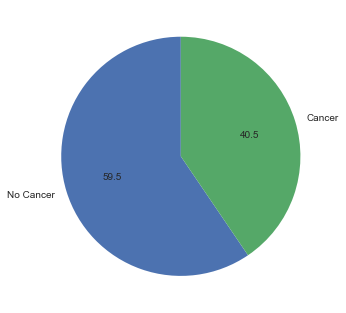

In [77]:
plt.pie(labels.label.value_counts(), labels=['No Cancer', 'Cancer'], 
         autopct='%1.1f', startangle=90);

## Plot training metrics

In [78]:
training_data = {
    "Baseline CNN" : f"{model_data_folder}/baseline_cnn_train.csv",
    "AlexNet Transfer Learning": f"{model_data_folder}/alexnet_train.csv"
}

### Load model data

In [79]:
for k, v in training_data.items():
    training_data[k] = pd.read_csv(v)
    training_data[k] = training_data[k].drop(["Unnamed: 0"], axis=1)
    
metrics = ["bce_loss","accuracy","precision","recall","f1_score"]

### Create plot for training data

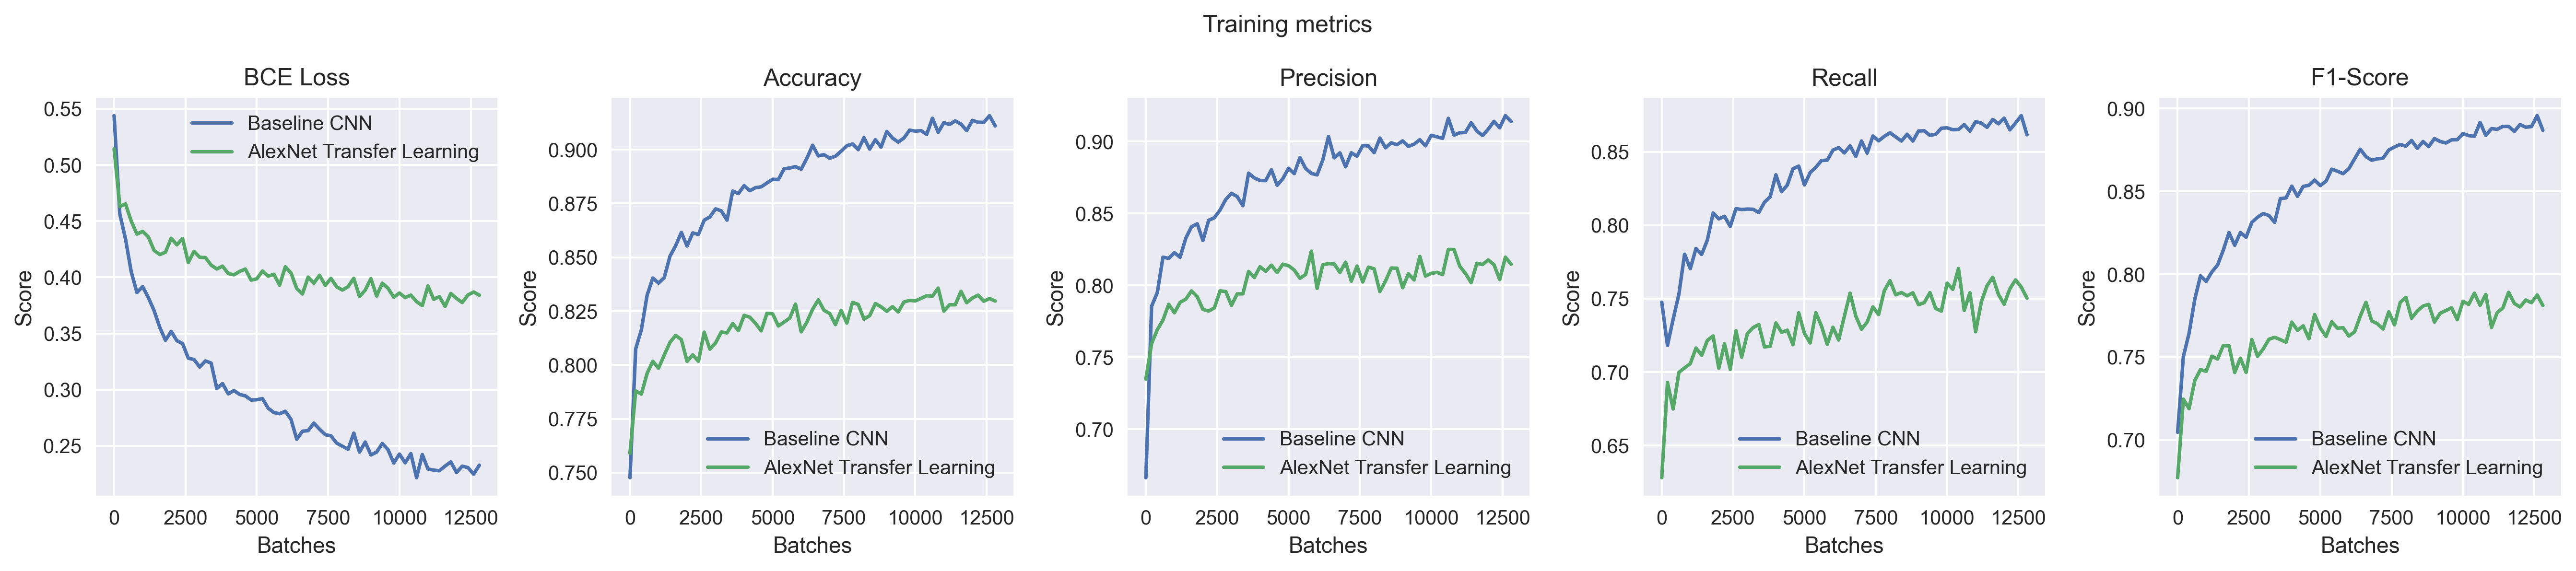

In [80]:
fig = plt.figure(figsize=(18,4), dpi=300)
fig.suptitle("Training metrics")
index = 1


for l in metrics:
    ax = fig.add_subplot(1, len(metrics), index)
    for k, m in training_data.items():
        ax.plot(m.index.values * 200, m[l], label=k)
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='Batches', ylabel="Score", title=name_mapping(l))
    index +=1
fig.tight_layout()

## Plot evaluation metrics

In [81]:
test_data = {
    "Baseline CNN" : f"{model_data_folder}/baseline_cnn_test.csv",
    "AlexNet Transfer Learning": f"{model_data_folder}/alexnet_test.csv"
}

### Load model data

In [82]:
for k, v in test_data.items():
    test_data[k] = pd.read_csv(v)
    test_data[k] = test_data[k].drop(["Unnamed: 0"], axis=1)
    
metrics = ["accuracy","precision","recall","f1_score"]

### Create barplot for evaluation data

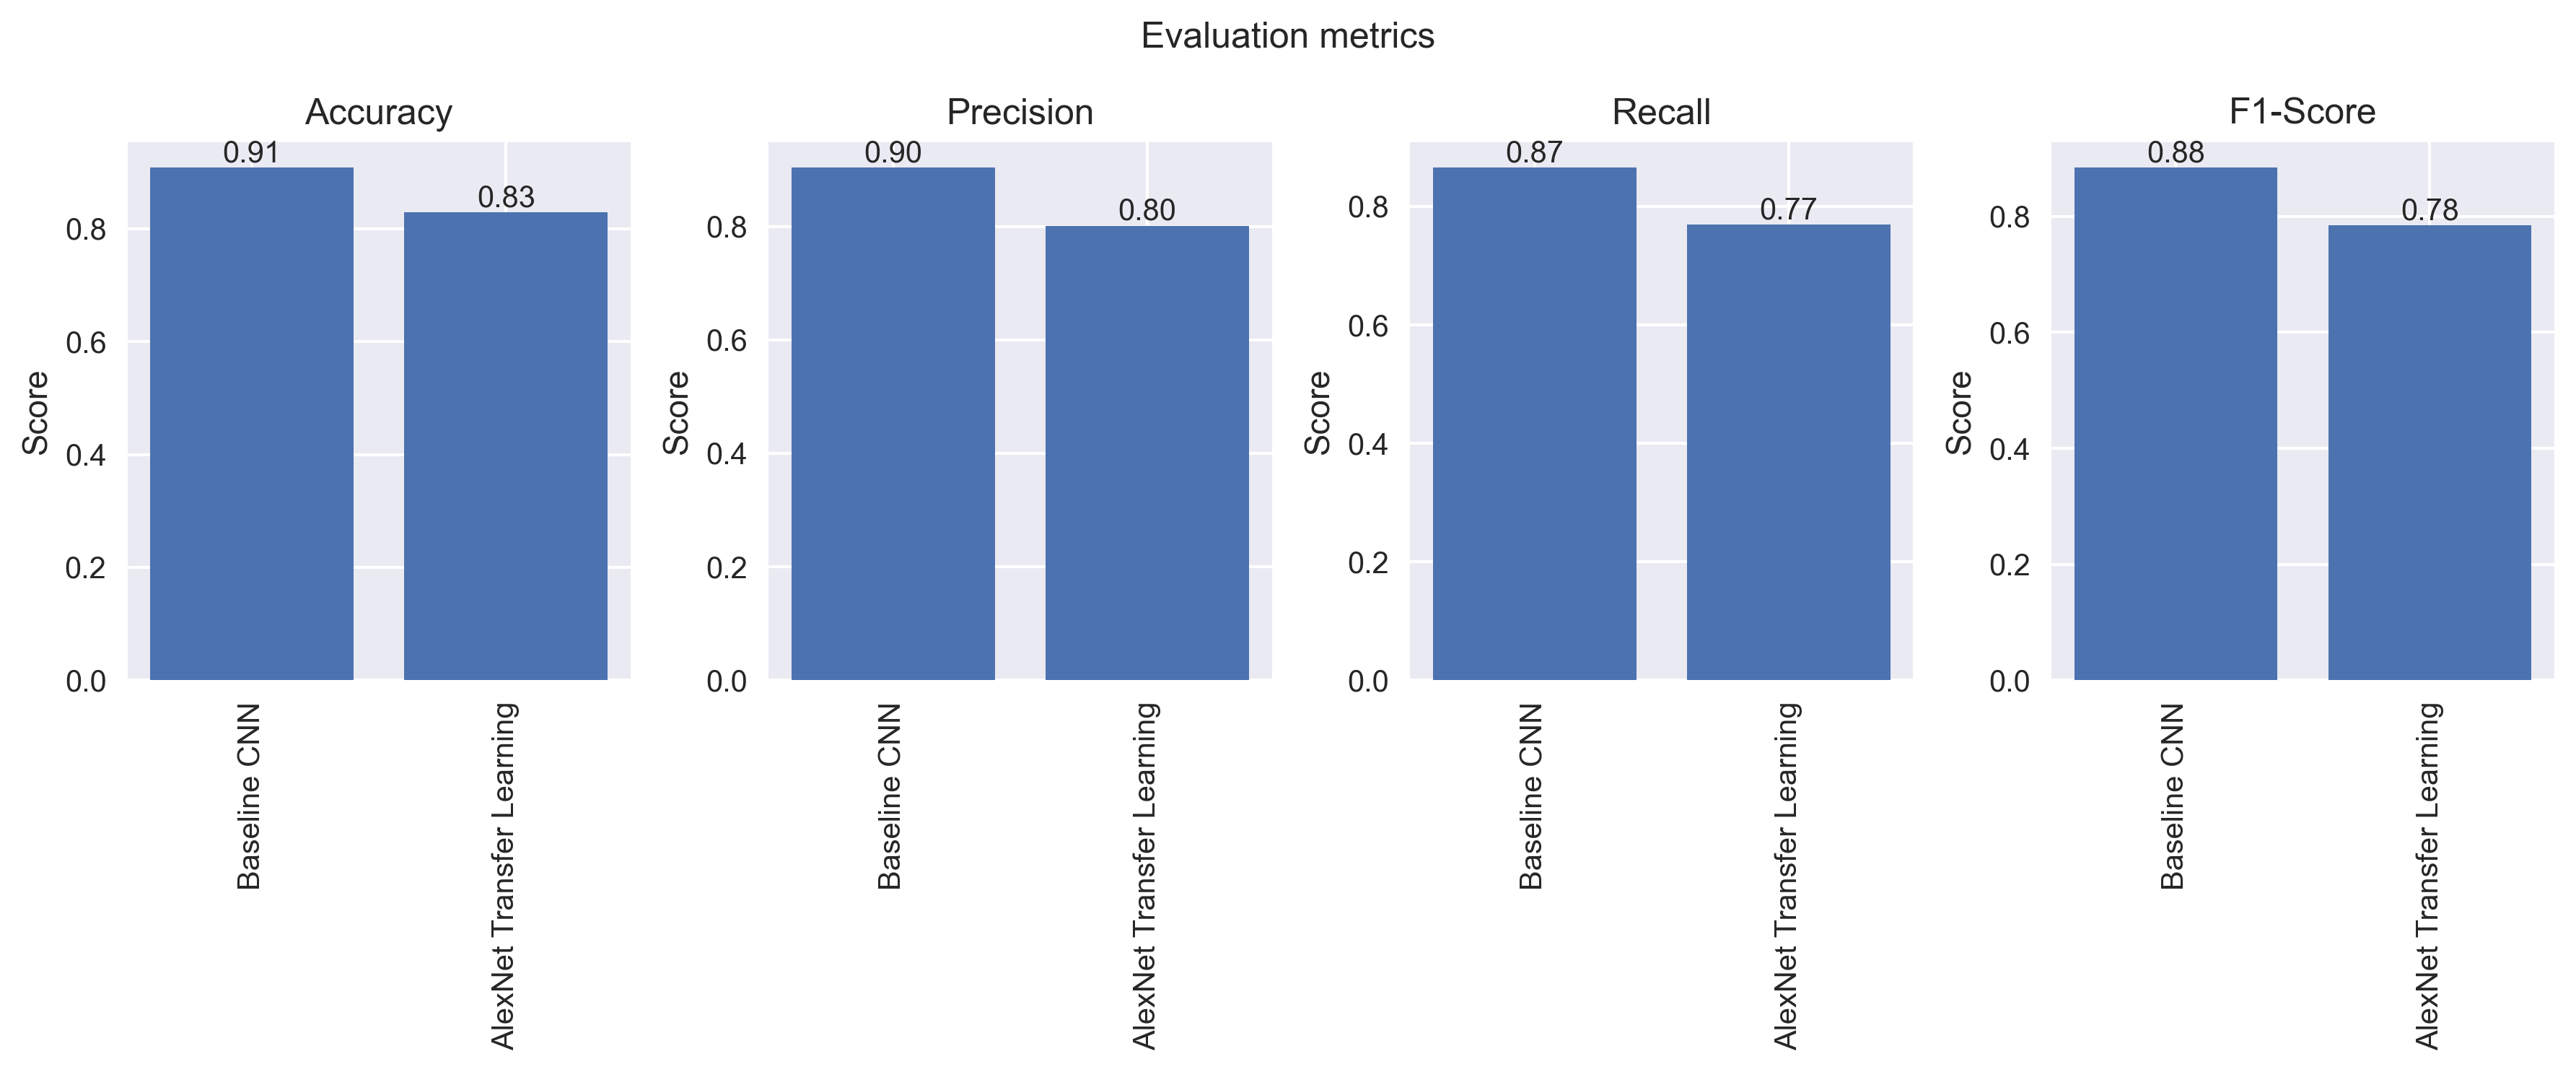

In [83]:
fig = plt.figure(figsize=(12,5), dpi=300)
fig.suptitle("Evaluation metrics")
index = 1

for l in metrics:
    ax = fig.add_subplot(1, 4, index)
    idx = range(len(test_data))
    values = []
    for k, m in test_data.items():
        values.append(m[l][0])
    bars = ax.bar(idx, values)
    ax.set_ylabel('Score')
    ax.set_title(name_mapping(l))
    ax.set_xticks(idx)
    ax.set_xticklabels(test_data, rotation='vertical')
    ax.bar_label(bars, fmt='%.2f')
    ax.grid(True)
    index = index + 1   
fig.tight_layout()

## Demonstrate image classification

### Randomly sample 20 images from test set

In [84]:
sample_batch = next(iter(test_loader))
imgs = sample_batch[0][:20]
labels = sample_batch[1][:20]

### Denormalize images for visualization

In [85]:
mean = torch.tensor([0.7025, 0.5463, 0.6965], dtype=torch.float32)
std = torch.tensor([0.2389, 0.2821, 0.2163], dtype=torch.float32)

# https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/20
inverse_normalization = transforms.Normalize((-mean/std).tolist(), (1.0/std).tolist())
imgs_display = inverse_normalization(imgs)

# Change channel order for matplotlib
imgs_display = (imgs_display.permute(0,2,3,1).numpy() * 255).astype(np.uint8)

### Load best model

In [86]:
path = f"{model_folder}/{best_model_name}.pth"
net = Net(img_dim=[3, 128, 128])
net.load_state_dict(torch.load(path))
net.cpu();

### Create predictions

In [87]:
preds = net(imgs)
preds = torch.gt(preds, 0.5).to(torch.uint8)

### Compare predictions with ground truth

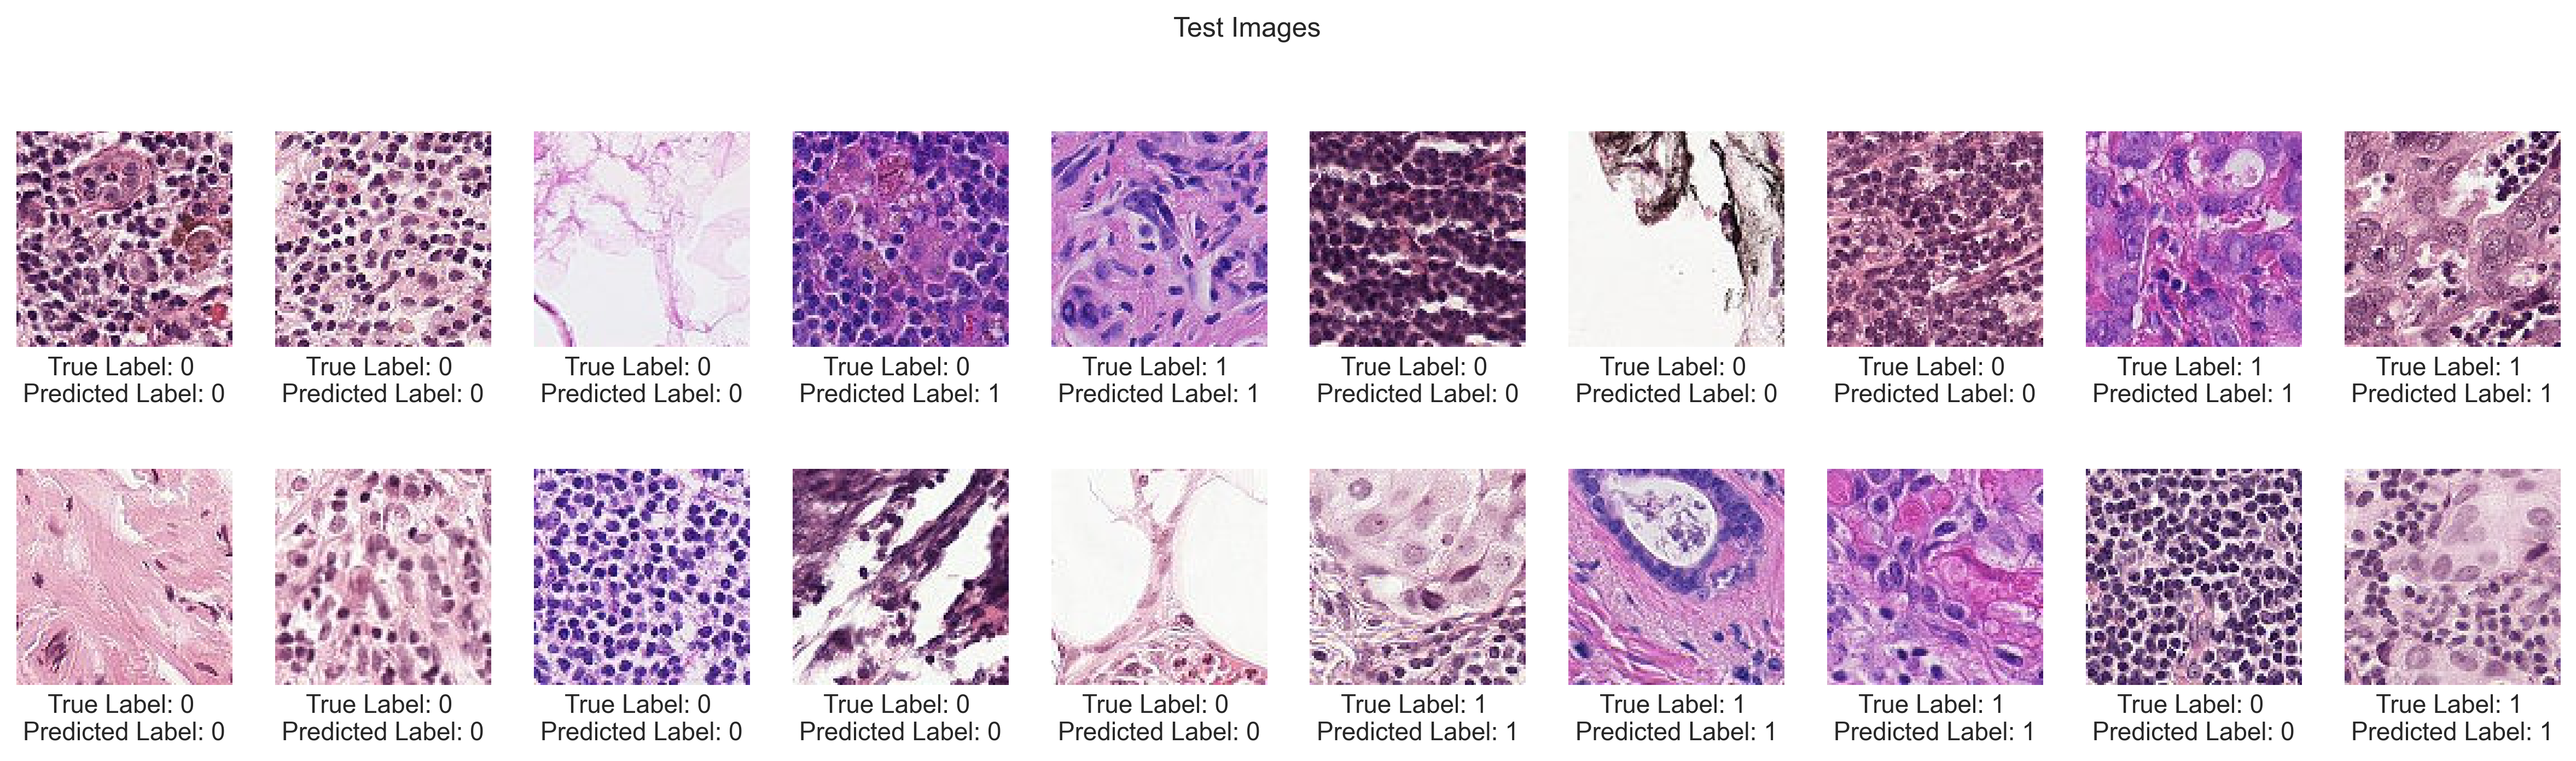

In [88]:
fig = plt.figure(figsize=(20, 5), dpi=300)
fig.suptitle("Test Images")
for i in range(1, 20 + 1):
    img = imgs_display[i-1]
    fig.add_subplot(2, 10, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"True Label: {labels[i-1].item()} \nPredicted Label: {preds[i-1].item()}")
plt.show()